In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from ShapeDataset import *
from implementations import *

In [2]:
########### Setting parameters ###########

googleColab = False     # Specify if you are currently using google colab or not
num_epochs = 2          # Number of epochs to train the model
hidden_layer = 1024      
set_num_workers = 2 if torch.cuda.is_available() else 0 # Number of workers, recommended max 2. Without a gpu it needs to be zero

shape = 'Spheres' # Must correspond to a folder with image and mask folders

if googleColab:
    root = '/content'
else:
    # Specify the path to the folder where your image and mask folders are
    root = f'./{shape}'

images_dir = os.path.join(root, 'images')
masks_dir  = os.path.join(root, 'masks')


In [3]:
#idx = 0
#img = Image.open(os.path.join(images_dir, images[idx])).convert("RGB")
#mask = Image.open(os.path.join(masks_dir, masks[idx]))
#img
#Image.fromarray(np.array(mask) == 3)

In [4]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [5]:
# Get a sorted lists of file names in the "images" and 'masks' directories
images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))

train_imgs, val_imgs, train_masks, val_masks = getTrainVal(images, masks)

train_dl = get_dataloader(train_imgs, train_masks, root, set_num_workers)
val_dl   = get_dataloader(  val_imgs,   val_masks, root, set_num_workers)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device = }')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

device = device(type='cpu')


In [7]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(num_epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i in range(len(train_dl)):
        dt = next(iter(train_dl))
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
      for j in range(len(val_dl)):
            dt = next(iter(val_dl))  # Get the next batch
            imgs = [dt[0][0].to(device), dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
    all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.7117, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.5718, grad_fn=<DivBackward0>), 'loss_mask': tensor(2.2436, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6918, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1970, grad_fn=<DivBackward0>)}
0    16.76484775543213    8.72472095489502
1    15.557445287704468    2.7614481449127197


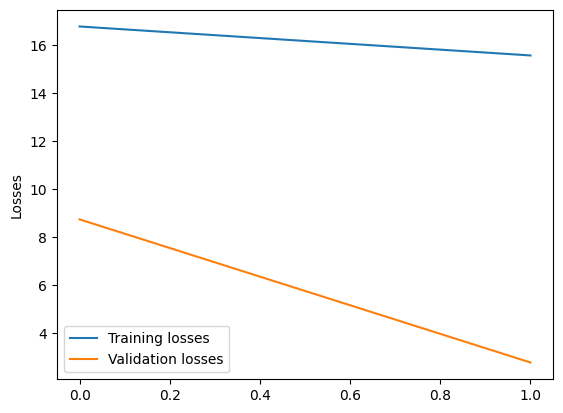

In [8]:
plt.plot(all_train_losses)
plt.plot(all_val_losses)
plt.legend(['Training losses','Validation losses'])
plt.ylabel('Losses')
plt.show()

In [9]:
model.eval()
img = Image.open("./Picture184.png").convert("RGB")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

FileNotFoundError: [Errno 2] No such file or directory: './Picture184.png'

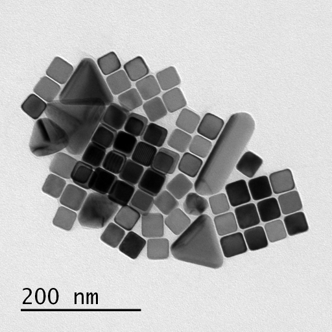

In [ ]:
img

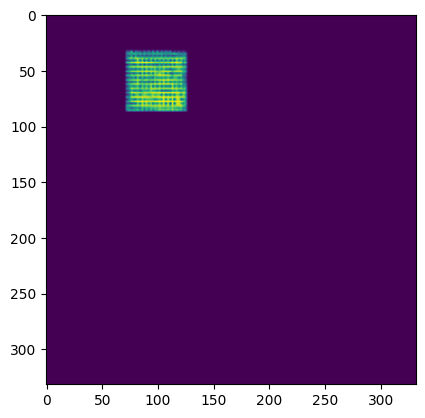

In [ ]:
plt.imshow((pred[0]["masks"][15].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [ ]:
from torchvision.transforms import v2 as T
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

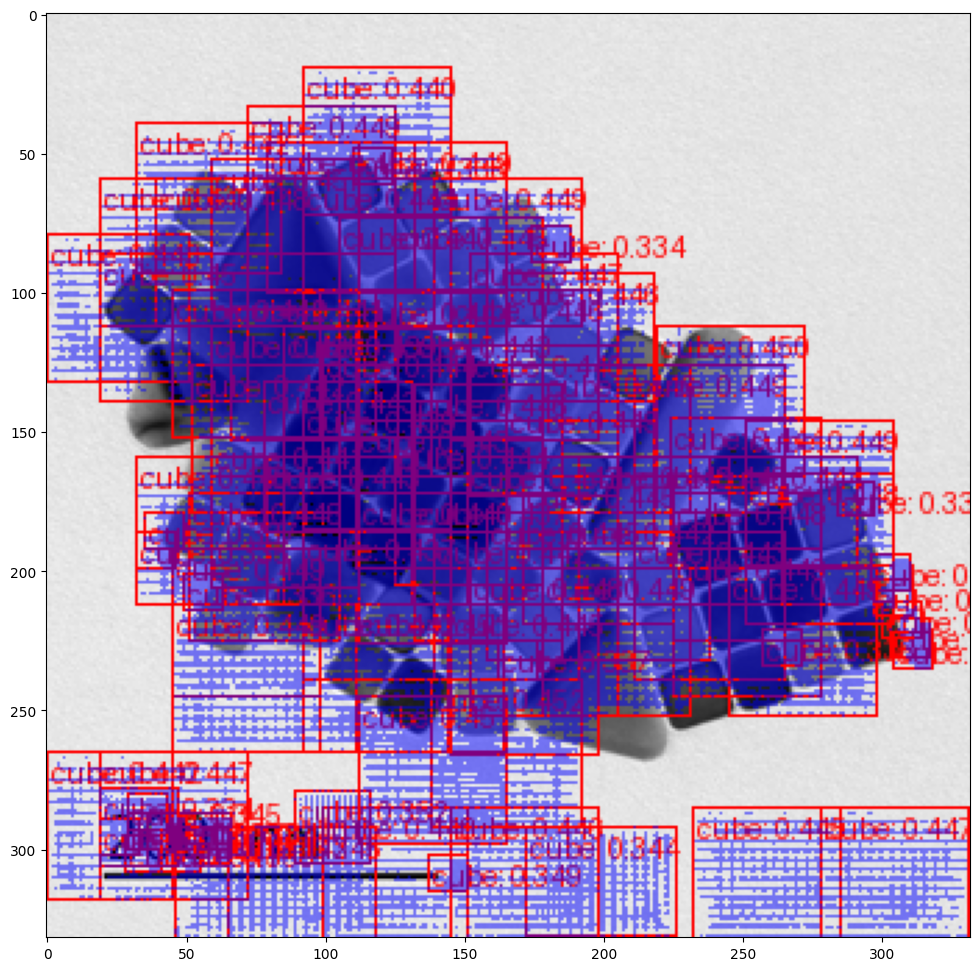

In [ ]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("./Picture184.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cube: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
img.size

(332, 332)

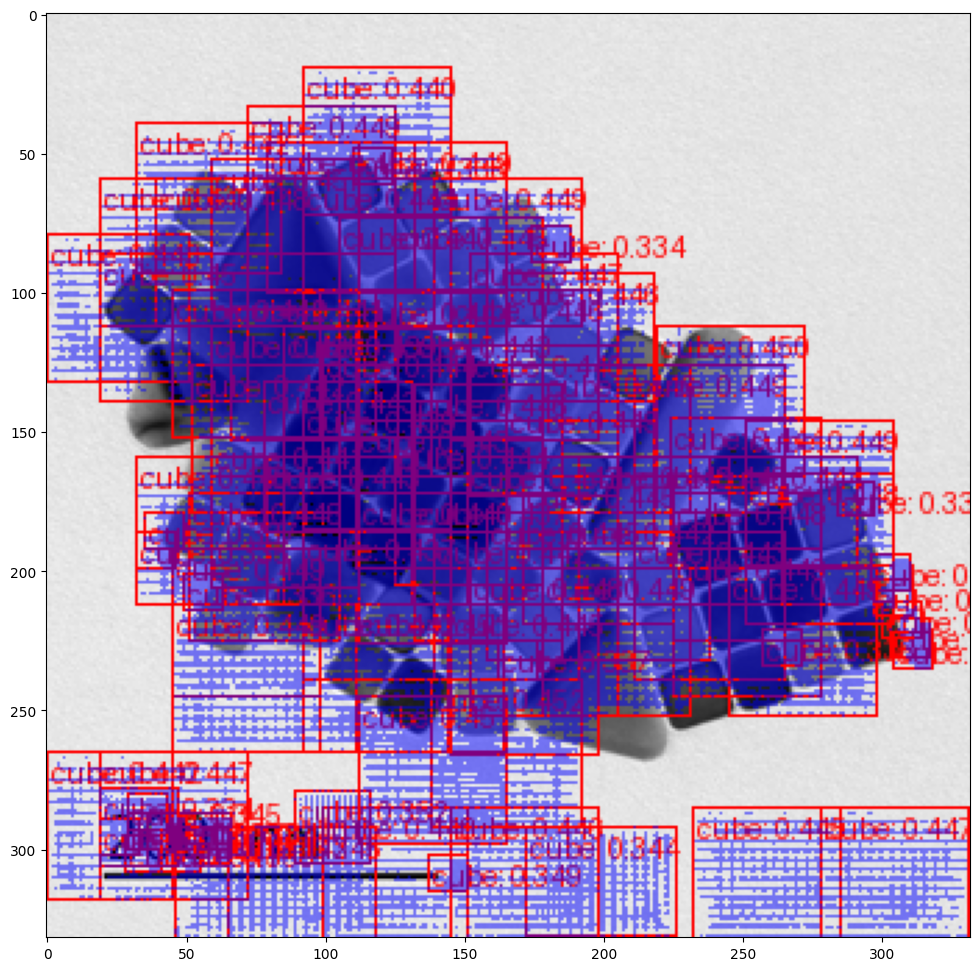

In [ ]:
image = read_image("./Picture184.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cube: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))